In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt.learning import ExtraTreesRegressor as opt_ETR
from scipy.stats import norm
import random
import warnings
warnings.filterwarnings("ignore")


random.seed(1126)
np.random.seed(1126)


plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'

In [7]:
data = pd.read_csv('data/proposed.csv').drop('Unnamed: 0', axis = 1)

idx =(data.loc[:, 'Li':'Bi'] > 0).sum() == 0
data = data.drop(list(data.loc[:, 'Li':'Bi'].columns[idx]), axis = 1)

#data.loc[:, "Contact time, s"] = np.log(data.loc[:, "Contact time, s"])
feat = data.loc[:, "Li":'Contact time, s']
target = data.loc[:, 'Y(C2), %']
#feat.index = np.arange(30)
#target.index = np.arange(30)

desc = pd.read_csv("data/Descriptors.csv", skiprows=[0], index_col="symbol")
desc.drop(
    [
        "Unnamed: 0",
        "AN",
        "name",
        "period",
        "ionic radius",
        "covalent radius",
        "group",
        "VdW radius",
        "crystal radius",
        "a x 106 ",
        "Heat capacity ",
        "l",
        "electron affinity ",
        "VE",
        "Surface energy ",
    ],
    axis=1,
    inplace=True,
)
desc = desc.fillna(desc.mean())
for i in range(8):
    feat = feat.drop([f"{i+1}_ionization enegy", f"{i+1}_AW", f"{i+1}_atomic radius",f"{i+1}_m. p.",f"{i+1}_b. p.", ], axis =1)
    

comp =feat.loc[:,"Li":"Bi"].columns
prep = feat.loc[:,'Impregnation':'Pechini method'].columns
cond = feat.loc[:, 'Temperature, K':'Contact time, s'].columns
prom = feat.loc[:, 'Promotor_Cl':'Promotor_F'].columns
metal= feat.loc[:, '1_electronegativity':'8_density'].columns
cols = list(prep) + list(cond)
columns = list(comp) + list(prom) + list(prep) + list(cond)
random_state =1126

conventional = columns
proposed = list(comp)+ list(metal) + list(prom) + list(prep) + list(cond)
proposed2 =  list(metal) + list(prom) + list(prep) + list(cond)
print(data.shape)

desc

(4387, 172)


,AW,atomic radius,electronegativity,m. p.,b. p.,delta_fus H,density,ionization enegy
symbol,,,,,,,,
Li,6.9410,1.67,0.97,453.69,1615.00,3.000,0.534,5.3917
Be,9.0122,1.12,1.47,1560.00,2742.00,7.895,1.850,9.3227
B,10.8110,0.87,2.01,2349.00,4200.00,50.200,2.340,8.2980
C,12.0107,0.67,2.50,3800.00,4300.00,117.000,2.200,11.2603
N,14.0067,0.56,3.07,63.05,77.36,0.710,3.513,14.5341
...,...,...,...,...,...,...,...,...
Pt,195.0840,1.77,1.44,2041.40,4098.00,22.170,21.500,8.9588
Au,196.9666,1.74,1.42,1337.33,3129.00,12.720,19.300,9.2255
Tl,204.3833,1.56,1.44,577.00,1746.00,4.140,11.800,6.1082


In [3]:
def posterior(x, p_x, p_y, model):
    """
    EIを計算する上でのμならびにσの計算(鈴木氏作成)
    """
    if len(p_x.shape) == 1:
        model.fit(p_x.reshape(-1, 1), p_y)
        mu, sigma = model.predict(x.reshape(-1, 1), return_std = True)
    else:
        model.fit(p_x, p_y)
        mu, sigma = model.predict(x, return_std = True)
    ind = np.where(sigma == 0)
    sigma[ind] = 1e-5
    return mu, sigma

def EI(mu, sigma, cur_max):
    """
    EIの計算(鈴木氏作成)
    """
    Z = (mu - cur_max)/ sigma
    ei = (mu - cur_max) * norm.cdf(Z) + sigma*norm.pdf(Z)
    return ei


def comp_times_base(comp, base, sort=False, times=True, attention=False):
    """
    elementからaddtional descriptorに変更するプログラム(鈴木氏作成)
    """
    count = 0
    for key, rows in comp.iterrows():
        
        stack = np.vstack((rows, base))
        if times == True:
            time = np.array(base) * np.array(rows)
            stack = np.vstack((rows, time))

        if sort == True:
            stack = pd.DataFrame(stack).sort_values(
                [0], ascending=False, axis=1)

        stack = pd.DataFrame(stack).iloc[1:, :]
        stack = np.array(stack)

        if count == 0:
            if attention:
                res = np.sum(stack, axis=1)
            else:
                res = np.array(stack.T.flatten())

            count += 1
        else:
            if attention:
                res = np.vstack((res, np.sum(stack, axis=1)))
            else:
                res = np.vstack((res, np.array(stack.T.flatten())))

            count += 1
    return res

In [4]:
def smac_conv(model, init_x, init_y, roen_func, desc, random_state = 1126):
    """
    SMAC　のメインプログラム(鈴木氏作成)
    """
    cur_max = init_y.max()
    sub_x = init_x
    init_x = init_x.loc[:,conventional]
    model.fit(np.array(init_x), np.array(init_y))
    print(model)
    mu, sigma =  posterior(np.array(init_x), np.array(init_x), init_y, model)
    ei =  EI(mu, sigma, init_y.max())
    ei = pd.Series(ei, index = init_x.index, name = 'ei')
    make_nei =pd.Series(True, index=init_x.index, name='make_nei')
    next_x = pd.concat([sub_x, ei, make_nei], axis =1)
    while next_x['make_nei'].sum() != 0:
        next_x = roen_func(next_x, init_y, model, desc)
        print(next_x['make_nei'].sum())
        
    cand = next_x
        
    return cand

def smac_prop(model, init_x, init_y, roen_func, desc, random_state = 1126):
    """
    SMAC　のメインプログラム(鈴木氏作成)
    """
    cur_max = init_y.max()
    sub_x = init_x
    init_x = init_x.loc[:,proposed]
    model.fit(np.array(init_x), np.array(init_y))
    print(model)
    mu, sigma =  posterior(np.array(init_x), np.array(init_x), init_y, model)
    ei =  EI(mu, sigma, init_y.max())
    ei = pd.Series(ei, index = init_x.index, name = 'ei')
    make_nei =pd.Series(True, index=init_x.index, name='make_nei')
    next_x = pd.concat([sub_x, ei, make_nei], axis =1)
    while next_x['make_nei'].sum() != 0:
        next_x = roen_func(next_x, init_y, model, desc)
        print(next_x['make_nei'].sum())
        
    cand = next_x
        
    return cand

In [5]:
def opt_function_conv(x, y ,model, desc,random_state =1126):
    """
    各実験ずみの点に対して4回近傍の探索を行い最もEIの高かった組成実験条件を返す
    """
    xx = x.iloc[:,:-2]
    neighbor = pd.DataFrame(index = x.columns)
    for key, row in xx.iterrows():
        count = 0
        nei_cand = []
        #print('ind={0}'.format(key))
        if x.loc[key, 'make_nei'] == True:

            for _ in range(30):
                row_ch = row.copy()
                
                row_ch = change_cols(row_ch)
                
                nei_cand.append(row_ch)
                

            nei_cand = pd.DataFrame(nei_cand, index =np.arange(len(nei_cand)))

            
            mu, sigma = model.predict(np.array(nei_cand.loc[:,conventional]), return_std=True)
            ind = y.values.argmax()
            cur_max = y.iloc[ind]
            ei = EI(mu, sigma, cur_max)
            ind = np.argmax(ei)
            cand = nei_cand.iloc[ind].copy()
            cand['ei'] = ei[ind]
            if x.loc[key, 'ei'] < cand['ei']:
                cand['make_nei'] = True
                neighbor = pd.concat([neighbor, cand], axis = 1)
            else:
                x.loc[key, 'make_nei'] = False
                neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                
        else:
            neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                                                    
    print('-----------')
    
    neighbor = neighbor.T
    neighbor.index = x.index
    return neighbor

def opt_function_prop(x, y ,model, desc,random_state =1126):
    """
    各実験ずみの点に対して4回近傍の探索を行い最もEIの高かった組成実験条件を返す
    """
    xx = x.iloc[:,:-2]
    neighbor = pd.DataFrame(index = x.columns)
    for key, row in xx.iterrows():
        count = 0
        nei_cand = []
        #print('ind={0}'.format(key))
        if x.loc[key, 'make_nei'] == True:

            for _ in range(30):
                row_ch = row.copy()
                
                row_ch = change_cols(row_ch)
                
                nei_cand.append(row_ch)
                

            nei_cand = pd.DataFrame(nei_cand, index =np.arange(len(nei_cand)))
            temp = comp_times_base(nei_cand.loc[:,comp],desc.loc[comp].T,sort=True,times=True)
            temp = pd.DataFrame(temp)
            temp = temp.iloc[:, :64].fillna(0)
            temp.columns = metal
            nei_cand = pd.concat([nei_cand.loc[:,comp],temp, nei_cand.loc[:, prom], nei_cand.loc[:,prep], nei_cand.loc[:, cond]], axis = 1)

            
            mu, sigma = model.predict(np.array(nei_cand.loc[:,proposed]), return_std=True)
            ind = y.values.argmax()
            cur_max = y.iloc[ind]
            ei = EI(mu, sigma, cur_max)
            ind = np.argmax(ei)
            cand = nei_cand.iloc[ind].copy()
            cand['ei'] = ei[ind]
            if x.loc[key, 'ei'] < cand['ei']:
                cand['make_nei'] = True
                neighbor = pd.concat([neighbor, cand], axis = 1)
            else:
                x.loc[key, 'make_nei'] = False
                neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                
        else:
            neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                                                    
    print('-----------')
    
    neighbor = neighbor.T
    neighbor.index = x.index
    return neighbor


def change_cols(row_ch):
    cols =list(comp) + list(prep) + list(cond)
    x_ch = data
    
    change_f = random.choice(cols)
    
    if change_f in comp:
        a = np.array(row_ch[change_f]) - x_ch[change_f].min()
        b = x_ch[change_f].max() - x_ch[change_f].min()
        v = a / b
        p = -1
        while (p < 0) | (p > 1):
            p = random.normalvariate(v, 0.2)

        p = p * b + x_ch[change_f].min()
        row_ch[change_f] = p
    
    if change_f in cond:
        a = np.array(row_ch[change_f]) - x_ch[change_f].min()
        b = x_ch[change_f].max() - x_ch[change_f].min()
        v = a / b
        p = -1
        while (p < 0) | (p > 1):
            p = random.normalvariate(v, 0.2)

        p = p * b + x_ch[change_f].min()
        row_ch[change_f] = p

    elif change_f in prep:
        row_ch[change_f] = 1
        ind = set(prep) - {change_f}
        row_ch[ind] = 0
        
    return row_ch
        
    

In [76]:
model = opt_ETR(n_estimators = 500, random_state = 1126, n_jobs = -1)
cand_conv = smac_conv(model, feat, target, opt_function_conv, desc, random_state = 1126)

ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=1126)


KeyboardInterrupt: 

In [57]:
cand_conv.to_csv('out/smac_conv.csv')

Index(['1_AW', '1_atomic radius', '1_electronegativity', '1_m. p.', '1_b. p.',
       '1_delta_fus H', '1_density', '1_ionization enegy', '2_AW',
       '2_atomic radius', '2_electronegativity', '2_m. p.', '2_b. p.',
       '2_delta_fus H', '2_density', '2_ionization enegy', '3_AW',
       '3_atomic radius', '3_electronegativity', '3_m. p.', '3_b. p.',
       '3_delta_fus H', '3_density', '3_ionization enegy', '4_AW',
       '4_atomic radius', '4_electronegativity', '4_m. p.', '4_b. p.',
       '4_delta_fus H', '4_density', '4_ionization enegy', '5_AW',
       '5_atomic radius', '5_electronegativity', '5_m. p.', '5_b. p.',
       '5_delta_fus H', '5_density', '5_ionization enegy', '6_AW',
       '6_atomic radius', '6_electronegativity', '6_m. p.', '6_b. p.',
       '6_delta_fus H', '6_density', '6_ionization enegy', '7_AW',
       '7_atomic radius', '7_electronegativity', '7_m. p.', '7_b. p.',
       '7_delta_fus H', '7_density', '7_ionization enegy', '8_AW',
       '8_atomic radius', 

In [ ]:
model = opt_ETR(n_estimators = 500, random_state = 1126, n_jobs = -1)
cand_prop = smac_prop(model, feat, target, opt_function_prop, desc, random_state = 1126)

In [ ]:
cand_prop.to_csv('out/smac_prop.csv')

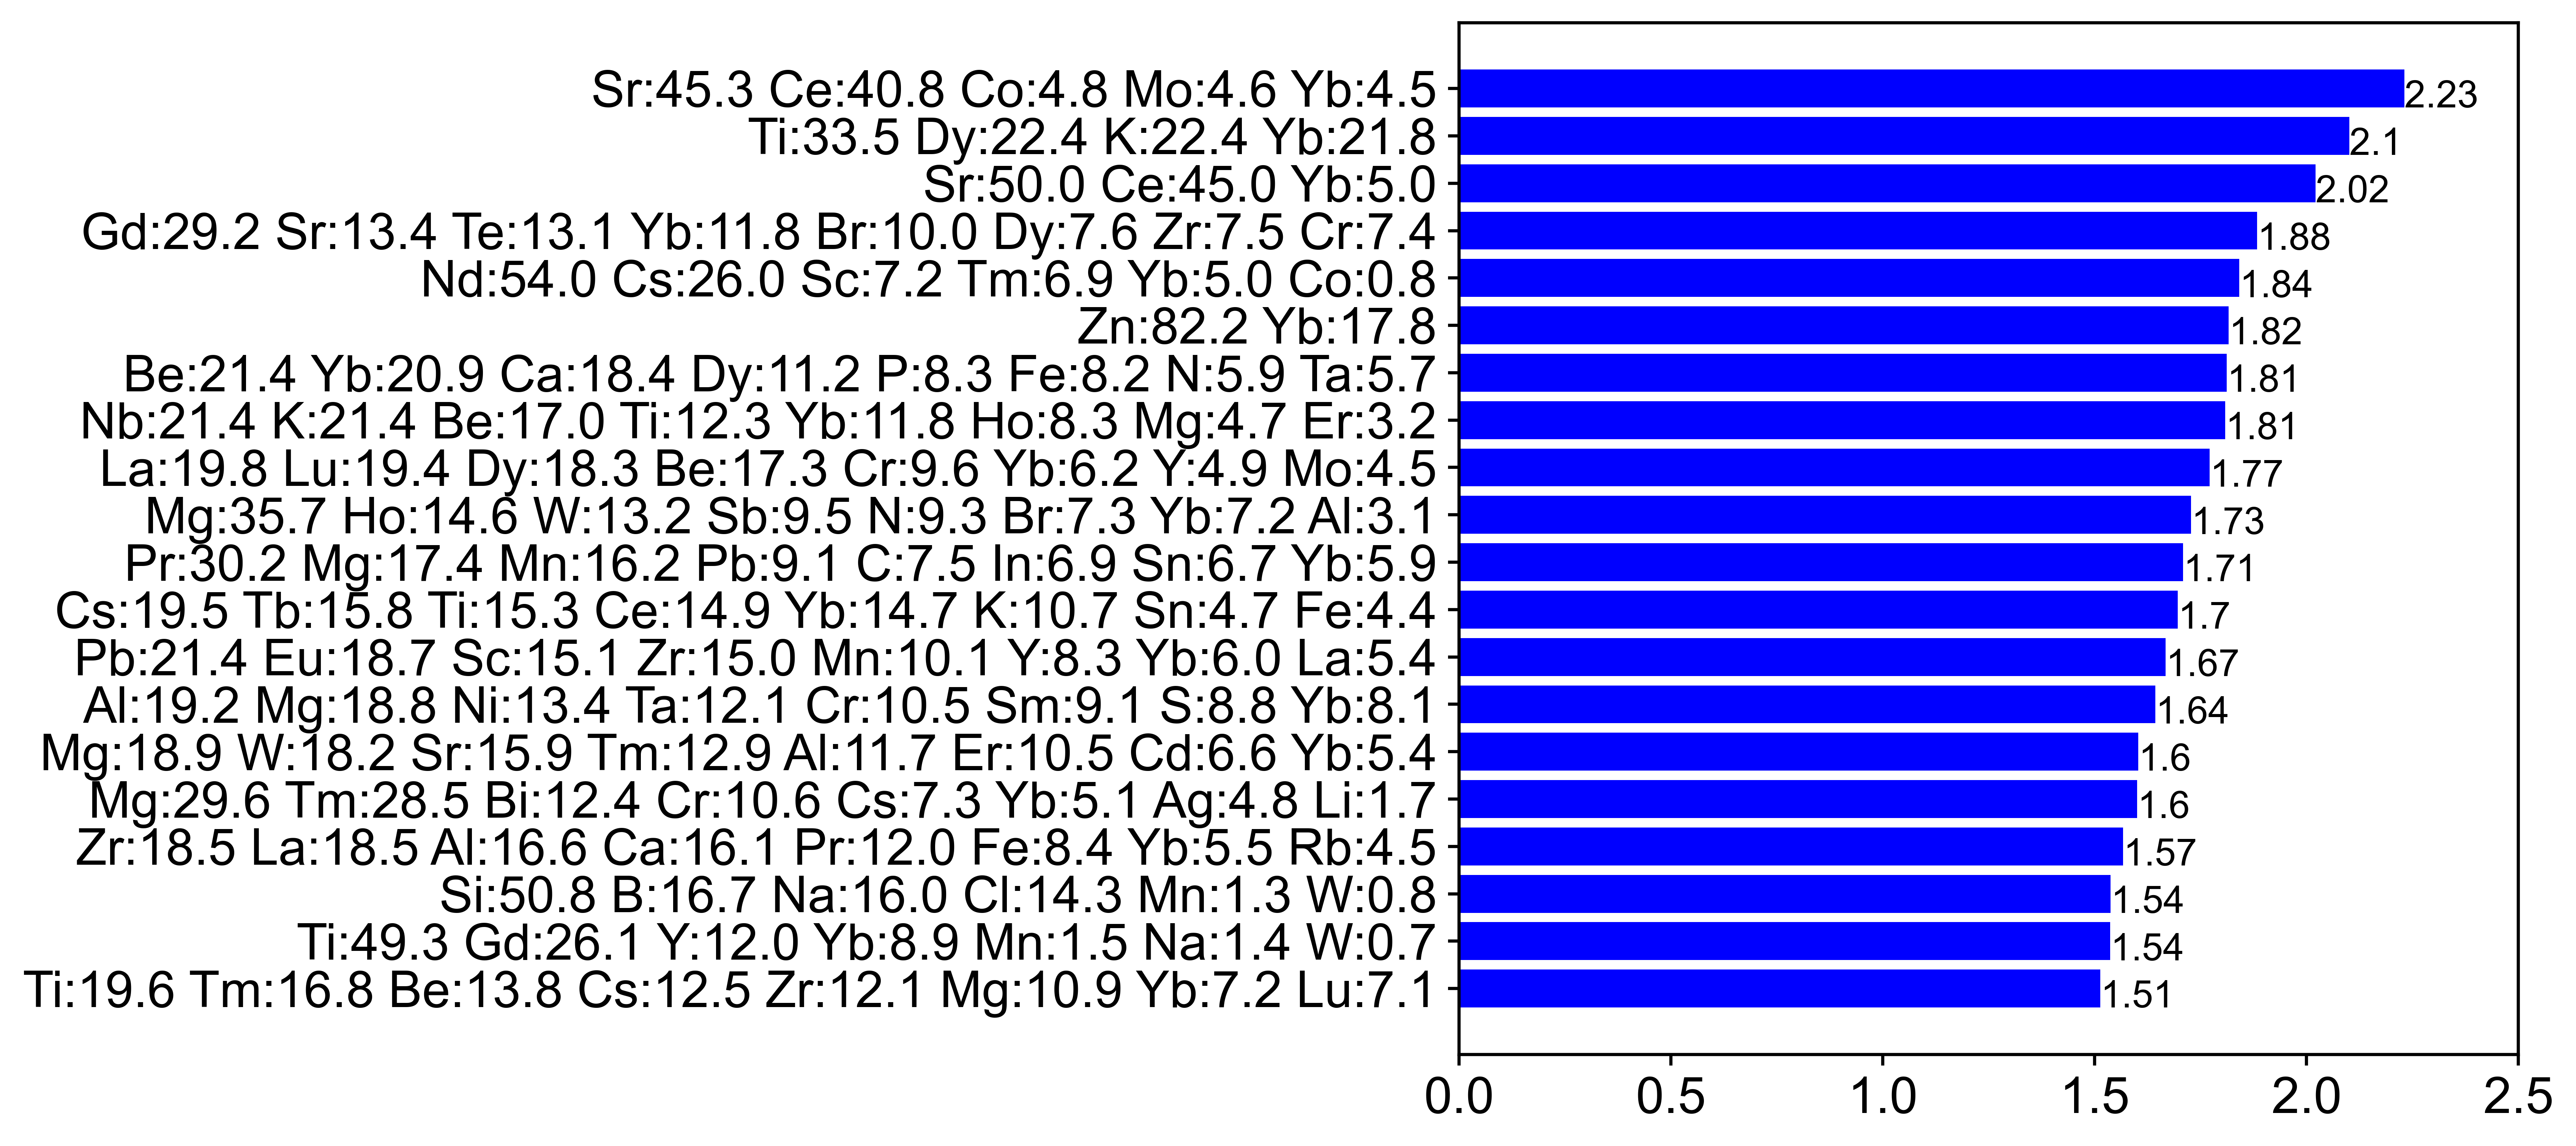

In [49]:
cand_conv = pd.read_csv('data/smac_conv.csv')
cand = cand_conv.copy()
#feat.loc[:,'Contact time, s'] = np.log10(feat.loc[:,'Contact time, s'])
from sklearn.cluster import KMeans
feat = data.loc[:,conventional]
model = opt_ETR(n_estimators = 500, n_jobs = -1)
k = KMeans(n_clusters=100, random_state=1126)
cluster = k.fit_predict(cand.iloc[:,:-1])
cluster = pd.Series(cluster, index=cand.index, name='cluster')
cand = pd.concat([cand,cluster], axis=1)
model.fit(feat, target)
pred_y = model.predict(cand.loc[:,conventional])
pred_y = pd.Series(pred_y, index = cand.index, name = 'pred_y')
cand = pd.concat([cand,pred_y], axis = 1)
#choose point which has most better ei value in each cluster
clus_high = cand.sort_values(by=['cluster','ei']).drop_duplicates(subset=['cluster'],keep='last')
clus_high = clus_high.sort_values(by='ei', ascending=False)

hogege = []
for key,row in clus_high.loc [:,comp].iterrows():
    temp = [str(i)+':'+str(round(v,1)) for i,v in row[row>0].sort_values(ascending=False).iteritems()]
    hogege.append(temp)
    
hogege = [' '.join(x) for x in hogege]

w = 0.4
hoge = clus_high.iloc[:20]
x = np.arange(hoge.shape[0])
pred_y = list(clus_high['pred_y'])
    
                
extra = []
for y in x:
    extra.append(y)
    
ytick = []
for n in range(20):
    ytick.append(hogege[n])
    
plt.figure(figsize=(6,6), dpi=600)
plt.barh(x,hoge['ei'][::-1],label='EI', color = 'blue')
for n,i in enumerate(x[::-1]):
    plt.text(clus_high['ei'].iloc[n],i-0.4,str(round(clus_high['ei'].iloc[n],2)),fontsize=12)

clus_high.index = np.arange(len(clus_high))
temp =clus_high.loc[:,"Temperature, K":"ei"]

prep_list = pd.Series(index = np.arange(len(clus_high)))

for s in prep:
    idx = clus_high.loc[:,s] > 0
    prep_list[idx] = s
    
prep_list = prep_list.fillna('n.a.')
temp = pd.concat([pd.DataFrame(prep_list), temp], axis = 1)
temp.index = hogege

plt.xlim([0,2.5])
plt.yticks(x[::-1],ytick)
#temp =clus_high.loc[:,"Temperature, K":"ei"]
#temp.index = hogege
temp.to_csv("out/Table_conventional.csv")
plt.savefig('out/ETR_conv.svg', format = 'svg', dpi = 600, bbox_inches = 'tight')

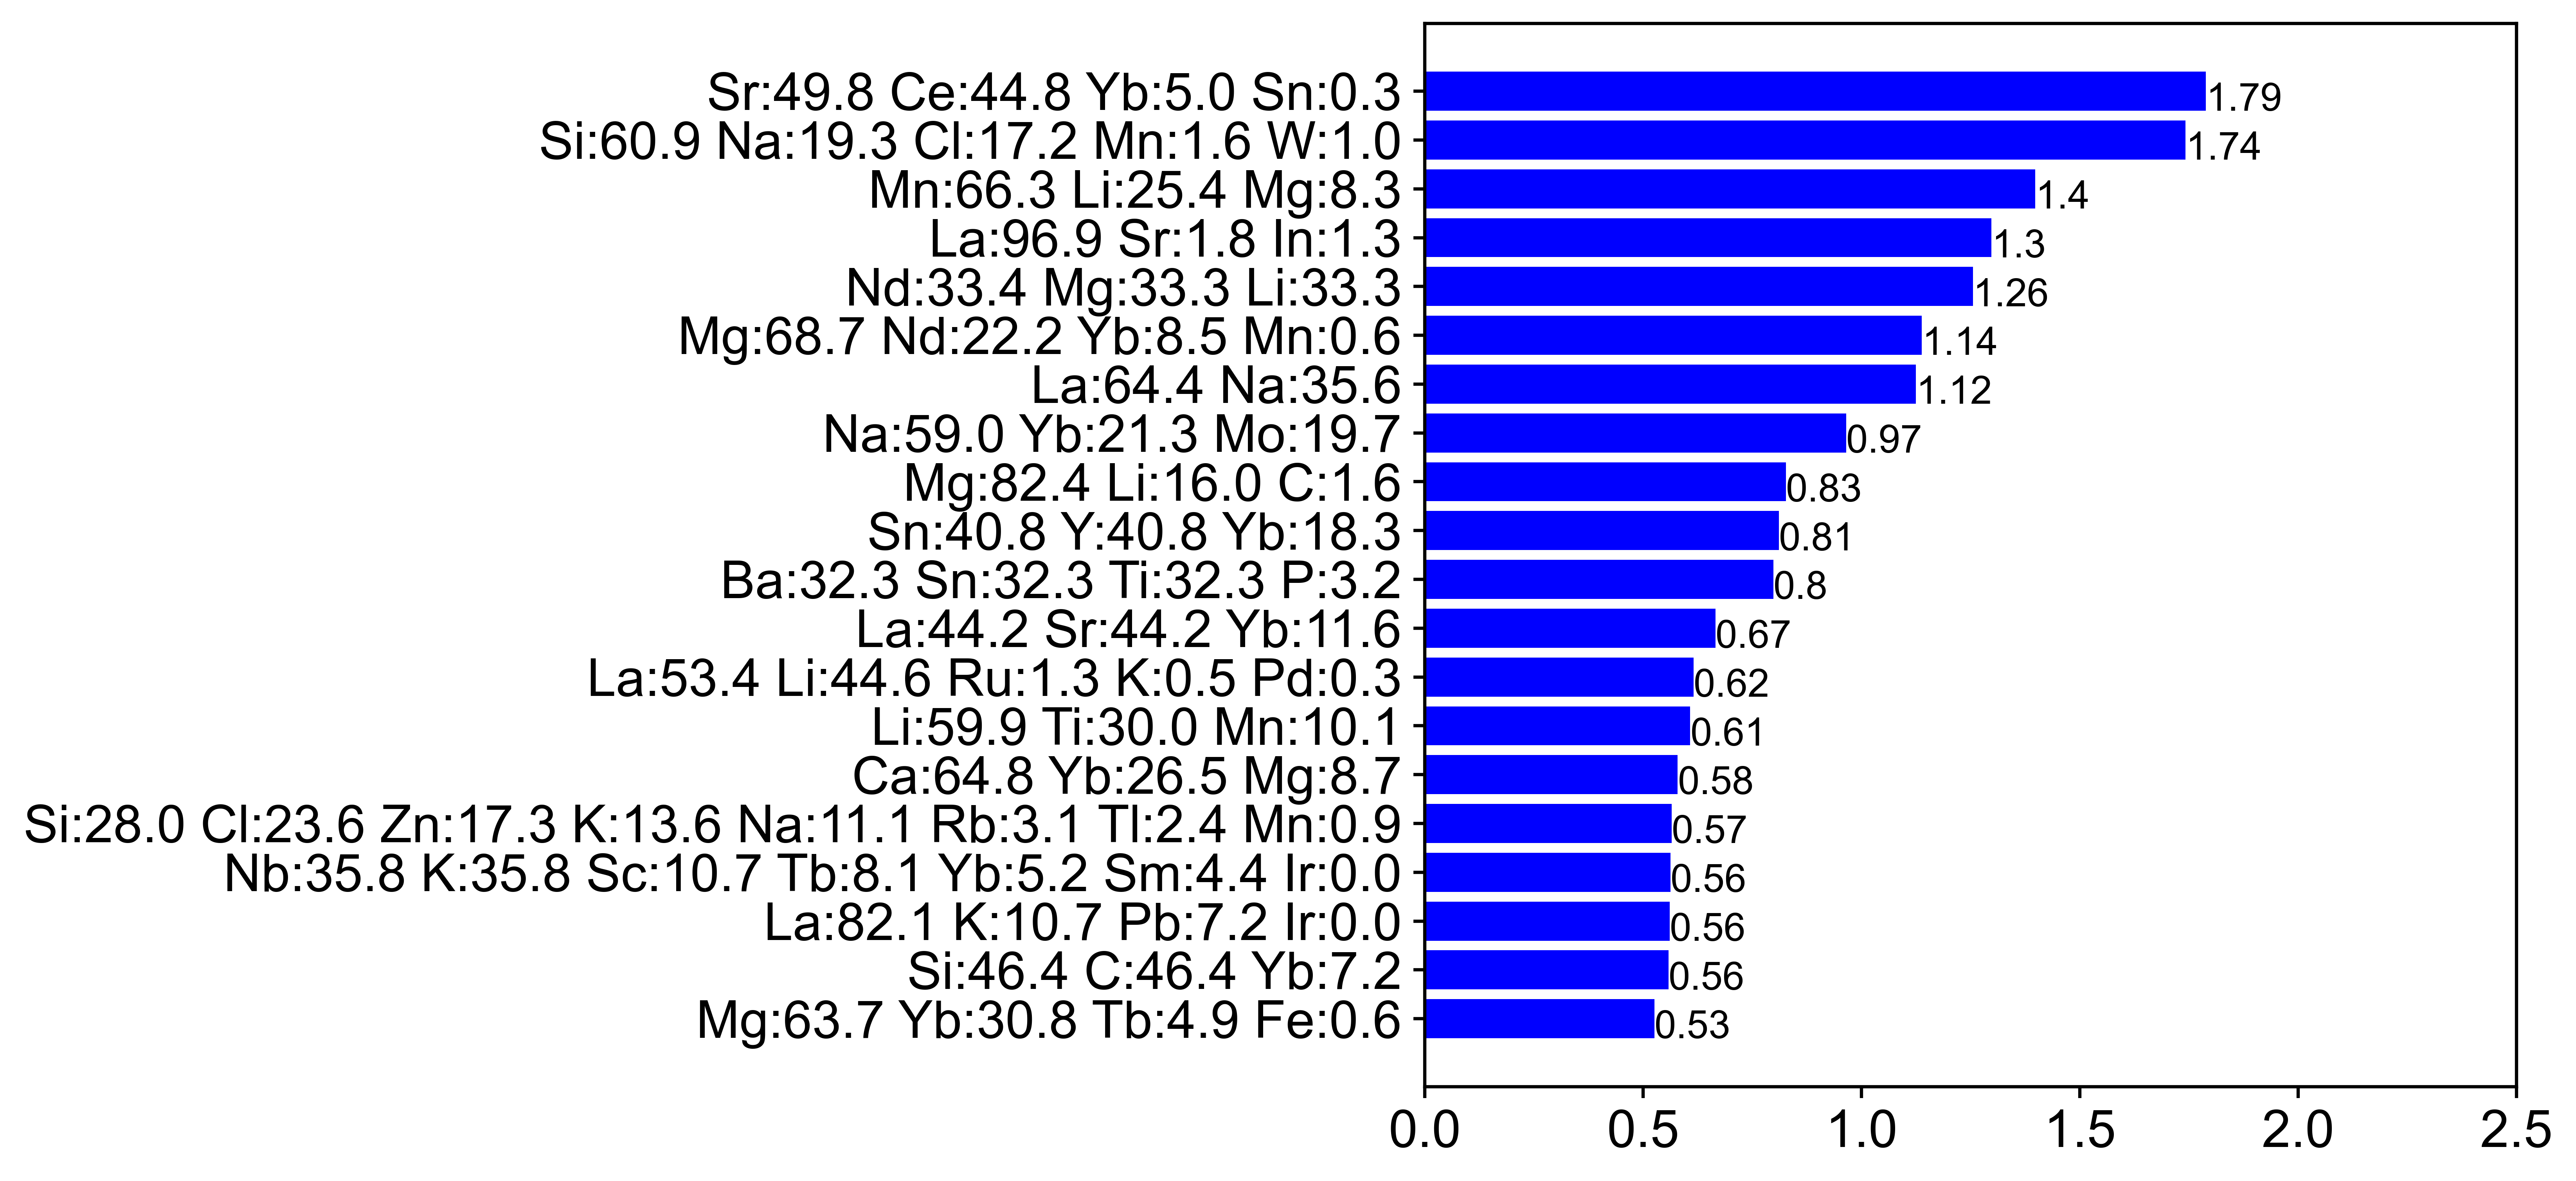

In [48]:
cand_conv = pd.read_csv('data/smac_prop.csv')
cand = cand_conv.copy()
#feat.loc[:,'Contact time, s'] = np.log10(feat.loc[:,'Contact time, s'])
from sklearn.cluster import KMeans
feat = data.loc[:,proposed]
model = opt_ETR(n_estimators = 500, n_jobs = -1)
k = KMeans(n_clusters=100, random_state=1126)
cluster = k.fit_predict(cand.iloc[:,:-1])
cluster = pd.Series(cluster, index=cand.index, name='cluster')
cand = pd.concat([cand,cluster], axis=1)
model.fit(feat, target)
pred_y = model.predict(cand.loc[:,proposed])
pred_y = pd.Series(pred_y, index = cand.index, name = 'pred_y')
cand = pd.concat([cand,pred_y], axis = 1)
#choose point which has most better ei value in each cluster
clus_high = cand.sort_values(by=['cluster','ei']).drop_duplicates(subset=['cluster'],keep='last')
clus_high = clus_high.sort_values(by='ei', ascending=False)

hogege = []
for key,row in clus_high.loc [:,comp].iterrows():
    temp = [str(i)+':'+str(round(v,1)) for i,v in row[row>0].sort_values(ascending=False).iteritems()]
    hogege.append(temp)
    
hogege = [' '.join(x) for x in hogege]

w = 0.4
hoge = clus_high.iloc[:20]
x = np.arange(hoge.shape[0])
pred_y = list(clus_high['pred_y'])
    
                
extra = []
for y in x:
    extra.append(y)
    
ytick = []
for n in range(20):
    ytick.append(hogege[n])
    
plt.figure(figsize=(6,6), dpi=600)
plt.barh(x,hoge['ei'][::-1],label='EI', color = 'blue')
for n,i in enumerate(x[::-1]):
    plt.text(clus_high['ei'].iloc[n],i-0.4,str(round(clus_high['ei'].iloc[n],2)),fontsize=12)
    
clus_high.index = np.arange(len(clus_high))
temp =clus_high.loc[:,"Temperature, K":"ei"]

prep_list = pd.Series(index = np.arange(len(clus_high)))

for s in prep:
    idx = clus_high.loc[:,s] > 0
    prep_list[idx] = s
    
prep_list = prep_list.fillna('n.a.')
temp = pd.concat([pd.DataFrame(prep_list), temp], axis = 1)
temp.index = hogege

plt.xlim([0,2.5])
plt.yticks(x[::-1],ytick)
#temp =clus_high.loc[:,"Temperature, K":"ei"]
#temp.index = hogege
temp.to_csv("out/Table_proposed.csv")
plt.savefig('out/ETR_prop.svg', format = 'svg', dpi = 300, bbox_inches = 'tight')

In [24]:
def crossvalid_plot(xx, yy, model, cvf, xylim = [0, 35]):
    err_trn = []
    err_tes = []
    r_2_tes = []
    r_2_trn = []
    count = 0
    for train_index, test_index in cvf.split(xx):
        count += 1
        x_trn = np.array(xx)[train_index]
        x_tes = np.array(xx)[test_index]
        y_trn = np.array(yy)[train_index]
        y_tes = np.array(yy)[test_index]
        model.fit(x_trn, y_trn)
        x_trn_pred = model.predict(x_trn)
        x_tes_pred = model.predict(x_tes)
        plt.scatter(y_tes, x_tes_pred, s = 3, label = f'Fold {count}')
        
    plt.plot([-100, 200], [-100, 200], c='0', ls='-', lw=1.0)
    plt.xlim(xylim)
    plt.ylim(xylim)
    plt.xlabel("Experimental Yield [%]")
    plt.ylabel("Predicted Yield [%]")
    #plt.legend()
    return

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
plt.figure(figsize = (6,6))
feat = data.loc[:, conventional]
target = data.loc[:, 'Contact time, s']
model = GridSearchCV(ExtraTreesRegressor(n_jobs = 1, random_state = 1126),
                     param_grid = {'n_estimators': [500, 1000]},
                     n_jobs = 5, cv = 5)

cvf = KFold(n_splits = 10, random_state = 1126, shuffle = True)

crossvalid_plot(feat, target, model, cvf)